# Data Prep

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime
import json
import sys, os
sys.path.append(os.path.abspath(".."))


In [2]:
from finHRL.preprocess.preprocessor import YahooDownloader

with open("../finHRL/preprocess/tickers/ticker_lists.json", "r") as f:
    data = json.load(f)

dow_30 = data["DOW_30"]
cryptos = data["CRYPTO_7"]

TRAIN_START_DATE = '2017-01-01'
TRAIN_END_DATE = '2022-01-01'
TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2023-01-01'



df = YahooDownloader(start_date = pd.to_datetime(TRAIN_START_DATE) - datetime.timedelta(days=30),
                     end_date = TEST_END_DATE,
                     ticker_list = dow_30).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (45900, 8)


In [3]:
INDICATORS = ['macd',
              'rsi_30',
              'cci_30']

from finHRL.preprocess.preprocessor import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

processed = processed[processed.date >= TRAIN_START_DATE].reset_index(drop=True)

Successfully added technical indicators


In [4]:
stock_dimension = len(processed.tic.unique())
print(stock_dimension)

30


In [5]:
df_train = processed[processed.date < TEST_START_DATE]
df_test = processed[processed.date >= TEST_START_DATE]


df_train["dayorder"] = df_train["date"].astype("category").cat.codes
df_test["dayorder"] = df_test["date"].astype("category").cat.codes

# Base RL

## Hyperparameter optimization

In [1]:
from dev.hyperparameter_searching.base_RL_hs import hyperparams_opt_RL

hs_opt = hyperparams_opt_RL(
    df_train=df_train,
    df_test=df_test,
    indicators=INDICATORS,
    n_episodes_train=10,
    n_trials=80
)

hs_opt.run_opt()

ModuleNotFoundError: No module named 'dev'

## Training

In [6]:
# TRAINING with BEST HPs
from finHRL.env_stocktrading.trading_env_RL import StockTradingEnv
from finHRL.agent.models import baseRLAgent

# state_space_noHRL = [balance, close prices_i, stock_shares_i, MACD_i, rsi30_i, cci30_i]
episode_len = df_train.dayorder.nunique()
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension 

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

tr_env = StockTradingEnv(
    df = df_train,
    stock_dim=stock_dimension,
    hmax= 100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space= state_space,
    action_space= stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=False,
    print_verbosity=2
)

agent = baseRLAgent(env=tr_env)

n_episodes = 200

#best_hiperparams = {'gamma': 0.9460266042874034,
#                    'max_grad_norm': 0.5723516016378004,
#                    'n_steps': 8,
#                    'learning_rate': 4.3336870145809356e-05,
#                    'ent_coef': 7.323986049778401e-08}

best_hiperparams= {'gamma': 0.9982572049354244, 'max_grad_norm': 1.004287538508153, 'n_steps': 256, 'learning_rate': 0.0002750235733375285, 'ent_coef': 6.465134048701665e-05}



model = agent.get_model("a2c",
                        learning_rate = best_hiperparams['learning_rate'],
                        gamma = best_hiperparams['gamma'],
                        max_grad_norm = best_hiperparams['max_grad_norm'],
                        n_steps = best_hiperparams['n_steps'],
                        ent_coef = best_hiperparams['ent_coef'],
                        verbose=1)


trained_model = agent.train_model(
    model,
    tb_log_name="a2c_best_hp",
    total_timesteps= n_episodes*episode_len
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/a2c_best_hp_6
day: 1258, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1765495.25
total_reward: 765495.25
total_cost: 211280.22
total_trades: 33919
Sharpe: 0.580
day: 1258, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 1909913.22
total_reward: 909913.22
total_cost: 222416.03
total_trades: 34316
Sharpe: 0.718
day: 1258, episode: 6
begin_total_asset: 1000000.00
end_total_asset: 1695956.18
total_reward: 695956.18
total_cost: 223539.09
total_trades: 34354
Sharpe: 0.578
day: 1258, episode: 8
begin_total_asset: 1000000.00
end_total_asset: 2349263.33
total_reward: 1349263.33
total_cost: 224278.25
total_trades: 34275
Sharpe: 0.945
day: 1258, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1631613.03
total_reward: 631613.03
total_cost: 208930.43
total_trades: 33738
Sharpe: 0.570
day: 1258, episode: 12
begin_total_asset: 1000000.00
end_total_asset: 17

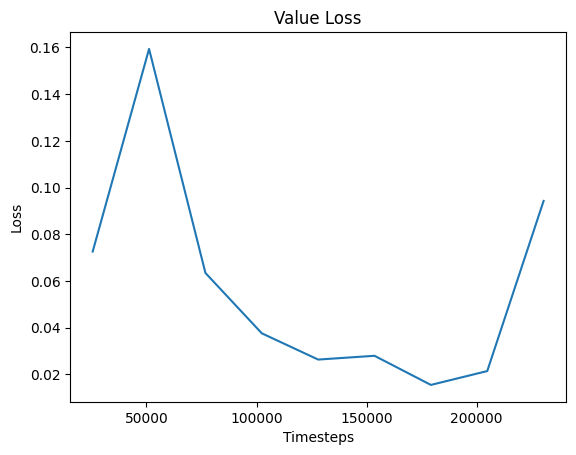

In [11]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

%matplotlib inline

ea = event_accumulator.EventAccumulator("logs/a2c_best_hp_6")  # cambia tu ruta
ea.Reload()

loss_key = "train/value_loss"
data = ea.Scalars(loss_key)

steps = [x.step for x in data]
values = [x.value for x in data]

plt.plot(steps, values)
plt.title("Value Loss")
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.show()

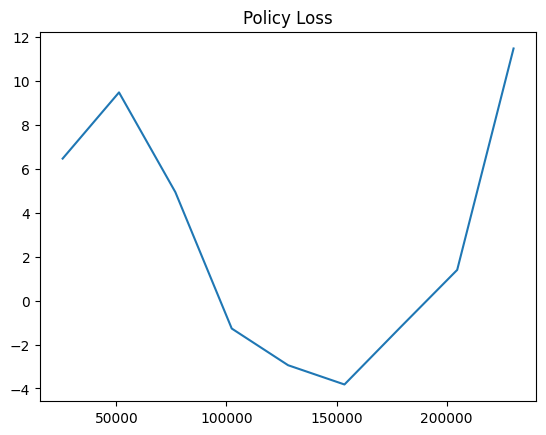

In [12]:
loss_key = "train/policy_loss"
data = ea.Scalars(loss_key)

plt.plot([x.step for x in data], [x.value for x in data])
plt.title("Policy Loss")
plt.show()

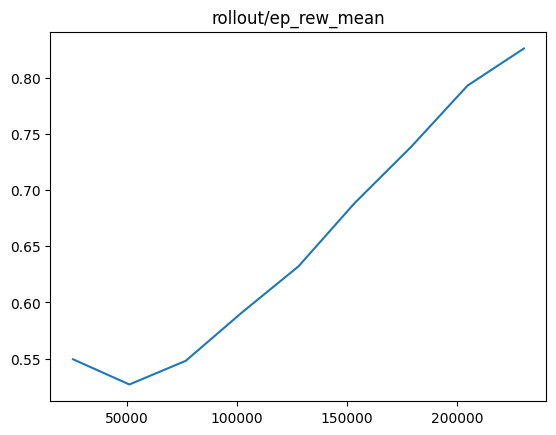

In [14]:
#loss_key = "train/entropy_loss"
loss_key = "rollout/ep_rew_mean"
data = ea.Scalars(loss_key)

plt.plot([x.step for x in data], [x.value for x in data])
plt.title(loss_key)
plt.show()

In [14]:
ea.Scalars("rollout/ep_rew_mean")

[ScalarEvent(wall_time=1763917584.412521, step=1600, value=0.5806970000267029),
 ScalarEvent(wall_time=1763917591.093463, step=2400, value=0.5806970000267029),
 ScalarEvent(wall_time=1763917597.9959612, step=3200, value=0.5900754928588867),
 ScalarEvent(wall_time=1763917604.708166, step=4000, value=0.6393623352050781),
 ScalarEvent(wall_time=1763917611.079505, step=4800, value=0.6393623352050781),
 ScalarEvent(wall_time=1763917619.771733, step=5600, value=0.632112979888916),
 ScalarEvent(wall_time=1763917626.7456949, step=6400, value=0.5852046012878418),
 ScalarEvent(wall_time=1763917633.554527, step=7200, value=0.5852046012878418),
 ScalarEvent(wall_time=1763917640.0176818, step=8000, value=0.5870109796524048),
 ScalarEvent(wall_time=1763917646.106862, step=8800, value=0.5870109796524048),
 ScalarEvent(wall_time=1763917652.729341, step=9600, value=0.5962212681770325),
 ScalarEvent(wall_time=1763917659.6449149, step=10400, value=0.5999690294265747),
 ScalarEvent(wall_time=1763917666.13

In [15]:
# TESTING
test_env = StockTradingEnv(
    df = df_test,
    stock_dim=stock_dimension,
    hmax= 100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space= state_space,
    action_space= stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=True,
    print_verbosity=1
)

df_account_value_a2c, df_actions_a2c = baseRLAgent.predict_RL(
    model=trained_model, 
    environment = test_env)

Starting prediction...
day: 250, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 734286.63
total_reward: -265713.37
total_cost: 2387.83
total_trades: 4614
Sharpe: -0.949
hit end!


In [16]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', None,
                       'display.max_colwidth', None):
    display(df_actions_a2c)




,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0,13,4,0,32,0,27,0,0,4,41,40,0,0,0,0,2,0,0,8,0,0,1,0,0,0,10,9,19,2
2022-01-04,0,13,4,0,32,0,27,0,0,4,41,40,0,0,0,0,2,0,0,8,0,0,1,0,0,0,10,9,19,2
2022-01-05,0,13,4,0,32,0,27,0,0,4,41,40,0,0,0,0,2,0,0,8,0,0,1,0,0,0,10,9,19,2
2022-01-06,0,13,4,0,32,0,27,0,0,4,41,40,0,0,0,0,2,0,0,8,0,0,1,0,0,0,10,9,19,2
2022-01-07,0,13,4,0,32,0,27,0,0,4,41,40,0,0,0,0,2,0,0,8,0,0,1,0,0,0,10,9,19,2
2022-01-10,0,13,4,0,32,0,27,0,0,4,41,40,0,0,0,0,2,0,0,8,0,0,1,0,0,0,10,9,19,2
2022-01-11,0,13,4,0,32,0,27,0,0,4,41,40,0,0,0,0,2,0,0,8,0,0,1,0,0,0,10,9,19,2
2022-01-12,0,13,4,0,32,0,27,0,0,4,41,40,0,0,0,0,2,0,0,8,0,0,1,0,0,0,10,9,19,2
2022-01-13,0,13,4,0,32,0,27,0,0,4,41,40,0,0,0,0,2,0,0,8,0,0,1,0,0,0,10,9,19,2


# HRL

In [ ]:
from finHRL.env_stocktrading.trading_env_HRL import StockTradingEnvHRL

# state_space_manager = [close prices_i, MACD_i, rsi30_i, cci30_i] Quizas quitar algún indicador

# state_space_worker = [balance, close_prices_i, stock_shares_i, manager_actions_i]                 # QUizás añadir agún indicador de riesgo a estudiar y hacer pruebas



# state_space_noHRL = [balance, close prices_i, stock_shares_i, MACD_i, rsi30_i, cci30_i]


# action_space_manager = {-1, 0, 1} * 30
# action_space_manager = {0,1} * 30 (para calcular cuántas, multiplicar por hmax)

episode_len = processed.dayorder.nunique()
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension

state_space_manager = (len(INDICATORS) + 1)*stock_dimension
state_space_worker = (1 + 3*stock_dimension)



buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension


tr_env = StockTradingEnvHRL(
    df = processed,
    stock_dim=stock_dimension,
    hmax= 100,
    initial_amount=1000000,
    num_stock_shares=num_stock_shares,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    state_space= state_space,
    action_space= stock_dimension,
    tech_indicator_list=INDICATORS,
    make_plots=True,
    print_verbosity=1
)

# Pendiente

- LR está en 0.0003: Probar a bajar a 5e-5 o 1e-5
- Incluir train -> Test etc